In [1]:
import os

from azure.core.credentials import AzureKeyCredential
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from dotenv import load_dotenv
import pandas as pd
from openai import AzureOpenAI
from azure.cosmos import PartitionKey
from azure.cosmos.cosmos_client import CosmosClient
import json

In [2]:
# Load environment variables
load_dotenv(override=True)

# Configuration
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_CHAT_MODEL = os.getenv("AZURE_OPENAI_CHAT_MODEL")
COSMOS_CONNECTION_STRING = os.getenv("COSMOS_CONNECTION_STRING")
COSMOS_DB_NAME = os.getenv("COSMOS_DB_NAME")
COSMOS_CONTAINER_NAME_CHAT = os.getenv("COSMOS_CONTAINER_NAME_CHAT")
SUBSCRIPTION_ID = os.getenv("SUBSCRIPTION_ID")
RESOURCE_GROUP_NAME = os.getenv("RESOURCE_GROUP_NAME")
PROJECT_NAME = os.getenv("PROJECT_NAME")

In [3]:
cosmos_client = CosmosClient.from_connection_string(COSMOS_CONNECTION_STRING)
database = cosmos_client.get_database_client(COSMOS_DB_NAME)
database.create_container_if_not_exists(
    id=COSMOS_CONTAINER_NAME_CHAT,
    partition_key=PartitionKey(path=f"/id"),
)
container = database.get_container_client(COSMOS_CONTAINER_NAME_CHAT)

In [4]:
query = 'SELECT VALUE { "query": c.question, "response": c.answer, "context": c.context, "ground_truth": "" } FROM ragchat c where c.role="eval"'
items = list(container.query_items(
    query=query,
    enable_cross_partition_query=True
))

import jsonlines

# JSONL形式でファイルに書き込む（UTF-8エンコーディング）
with open('./eval/input/eval_data.jsonl', mode='w', encoding='utf-8') as f:
    writer = jsonlines.Writer(f, dumps=lambda obj: json.dumps(obj, ensure_ascii=False))
    writer.write_all(items)

In [5]:
azure_ai_project = { 
    "subscription_id": SUBSCRIPTION_ID,
    "resource_group_name": RESOURCE_GROUP_NAME,
    "project_name": PROJECT_NAME
}

In [6]:
env_var = {
    "gpt-4o": {
        "endpoint": f"{AZURE_OPENAI_ENDPOINT}/deployments/{AZURE_OPENAI_CHAT_MODEL}/chat/completions?api-version=2024-06-01",
        "key": f"{AZURE_OPENAI_API_KEY}",
    },
}

In [7]:
output_folder = "./eval/output"

if not os.path.exists(output_folder):
	os.makedirs(output_folder)

### AI Eval

In [8]:
from azure.identity import AzureCliCredential
from azure.identity import InteractiveBrowserCredential

# ログの設定
logger = logging.getLogger('azure.identity')
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

# 認証情報の取得
credential = AzureCliCredential()

In [9]:
!az login
!az account set --subscription c9773603-7746-462c-973a-0891f3e93485

# 認証情報の取得
credential = DefaultAzureCredential()

[
  {
    "cloudName": "AzureCloud",
    "homeTenantId": "72f988bf-86f1-41af-91ab-2d7cd011db47",
    "id": "8c4b5b03-3b24-4ed0-91f5-a703cd91b412",
    "isDefault": false,
    "managedByTenants": [],
    "name": "Cosmos_C&E_Azure_AzureEngineeringSystems_100200",
    "state": "Enabled",
    "tenantId": "72f988bf-86f1-41af-91ab-2d7cd011db47",
    "user": {
      "name": "hnagasawa@microsoft.com",
      "type": "user"
    }
  },
  {
    "cloudName": "AzureCloud",
    "homeTenantId": "72f988bf-86f1-41af-91ab-2d7cd011db47",
    "id": "bac420ed-c6fc-4a05-8ac1-8c0c52da1d6e",
    "isDefault": false,
    "managedByTenants": [],
    "name": "IDEAs MS Reporting",
    "state": "Enabled",
    "tenantId": "72f988bf-86f1-41af-91ab-2d7cd011db47",
    "user": {
      "name": "hnagasawa@microsoft.com",
      "type": "user"
    }
  },
  {
    "cloudName": "AzureCloud",
    "homeTenantId": "72f988bf-86f1-41af-91ab-2d7cd011db47",
    "id": "88e54977-85c2-43c8-908a-34caf6c7b8a4",
    "isDefault": false,
    

2024-10-17 22:45:07,952 - azure.identity._credentials.environment - INFO - No environment configuration found.
2024-10-17 22:45:07,957 - azure.identity._credentials.managed_identity - INFO - ManagedIdentityCredential will use IMDS


In [10]:
# Initialize Azure OpenAI Connection with your environment variables
model_config = {
    "azure_endpoint": AZURE_OPENAI_ENDPOINT,
    "api_key": AZURE_OPENAI_API_KEY,
    "azure_deployment": AZURE_OPENAI_CHAT_MODEL,
    "api_version": "2024-06-01",
}

In [11]:
import pathlib
import random

from azure.ai.evaluation import RelevanceEvaluator, CoherenceEvaluator, GroundednessEvaluator, FluencyEvaluator
from azure.ai.evaluation import evaluate

#content_safety_evaluator = ContentSafetyEvaluator(project_scope=azure_ai_project)
relevance_evaluator = RelevanceEvaluator(model_config)
coherence_evaluator = CoherenceEvaluator(model_config)
groundedness_evaluator = GroundednessEvaluator(model_config)
fluency_evaluator = FluencyEvaluator(model_config)
#similarity_evaluator = SimilarityEvaluator(model_config=configuration)

path = "./eval/input/eval_data.jsonl"

randomNum = random.randint(1111, 9999)
result = evaluate(
    azure_ai_project=azure_ai_project,
    evaluation_name="Eval-Run-" + str(randomNum),
    data=path,
    evaluators={
        # "content_safety": content_safety_evaluator,
        "coherence": coherence_evaluator,
        "relevance": relevance_evaluator,
        "groundedness": groundedness_evaluator,
        "fluency": fluency_evaluator,
        #"similarity": similarity_evaluator,
    },
    # column mapping
    evaluator_config={
        "default": {
            "query": "${data.query}",
            "response": "${data.response}",
            "context": "${data.context}",
            "ground_truth": "${data.ground_truth}",
        },
    },
    # Optionally provide an output path to dump a json of metric summary, row level data and metric and studio URL
    #output_path="./",
)


2024-10-17 22:45:25,898 - azure.identity._internal.decorators - INFO - AzureCliCredential.get_token_info succeeded
2024-10-17 22:45:25,900 - azure.identity._internal.decorators - DEBUG - [Authenticated account] Client ID: 04b07795-8ddb-461a-bbee-02f9e1bf7b46. Tenant ID: 16b3c013-d300-468d-ac64-7eda0820b6d3. User Principal Name: unavailableUpn. Object ID (user): a00f95a2-67c6-423a-ad20-88cc530cfa00
2024-10-17 22:45:32,694 - azure.identity._internal.decorators - INFO - AzureCliCredential.get_token succeeded
2024-10-17 22:45:32,696 - azure.identity._internal.decorators - DEBUG - [Authenticated account] Client ID: 04b07795-8ddb-461a-bbee-02f9e1bf7b46. Tenant ID: 16b3c013-d300-468d-ac64-7eda0820b6d3. User Principal Name: unavailableUpn. Object ID (user): a00f95a2-67c6-423a-ad20-88cc530cfa00
[2024-10-17 22:45:35 +0900][promptflow][WARNING] - The starting prompt flow process returned an error: 'pf' �́A�����R�}���h�܂��͊O���R�}���h�A
����\�ȃv���O�����܂��̓o�b�` �t�@�C���Ƃ��ĔF������Ă��܂���B
. 
[

Starting prompt flow service...
Starting prompt flow service...
Starting prompt flow service...
Starting prompt flow service...


[2024-10-17 22:45:35 +0900][promptflow][WARNING] - The starting prompt flow process returned an error: 'pf' �́A�����R�}���h�܂��͊O���R�}���h�A
����\�ȃv���O�����܂��̓o�b�` �t�@�C���Ƃ��ĔF������Ă��܂���B
. 
[2024-10-17 22:45:37 +0900][promptflow][WARNING] - Prompt flow service is not healthy, please check the logs for more details; traces might not be exported correctly.
[2024-10-17 22:45:37 +0900][promptflow][WARNING] - Prompt flow service is not healthy, please check the logs for more details; traces might not be exported correctly.
[2024-10-17 22:45:38 +0900][promptflow][WARNING] - Prompt flow service is not healthy, please check the logs for more details; traces might not be exported correctly.
[2024-10-17 22:45:38 +0900][promptflow][WARNING] - Prompt flow service is not healthy, please check the logs for more details; traces might not be exported correctly.
[2024-10-17 22:45:38 +0900][promptflow._core.entry_meta_generator][WARNING] - Generate meta in current process and timeout won't t

2024-10-17 22:45:38 +0900   16728 execution.bulk     INFO     Current thread is not main thread, skip signal handler registration in BatchEngine.
2024-10-17 22:45:43 +0900   16728 execution.bulk     INFO     Finished 1 / 4 lines.
2024-10-17 22:45:43 +0900   16728 execution.bulk     INFO     Average execution time for completed lines: 5.37 seconds. Estimated time for incomplete lines: 16.11 seconds.
2024-10-17 22:45:43 +0900   16728 execution.bulk     INFO     Finished 2 / 4 lines.
2024-10-17 22:45:43 +0900   16728 execution.bulk     INFO     Average execution time for completed lines: 2.7 seconds. Estimated time for incomplete lines: 5.4 seconds.
2024-10-17 22:45:43 +0900   16728 execution.bulk     INFO     Finished 3 / 4 lines.
2024-10-17 22:45:43 +0900   16728 execution.bulk     INFO     Average execution time for completed lines: 1.85 seconds. Estimated time for incomplete lines: 1.85 seconds.
2024-10-17 22:45:44 +0900   16728 execution.bulk     INFO     Finished 4 / 4 lines.
2024-1

2024-10-17 22:45:46,136 - azure.identity._credentials.environment - INFO - No environment configuration found.
INFO:azure.identity._credentials.environment:No environment configuration found.
2024-10-17 22:45:46,137 - azure.identity._credentials.managed_identity - INFO - ManagedIdentityCredential will use IMDS
INFO:azure.identity._credentials.managed_identity:ManagedIdentityCredential will use IMDS
2024-10-17 22:45:46,153 - azure.identity._internal.decorators - DEBUG - EnvironmentCredential.get_token_info failed: EnvironmentCredential authentication unavailable. Environment variables are not fully configured.
Visit https://aka.ms/azsdk/python/identity/environmentcredential/troubleshoot to troubleshoot this issue.
Traceback (most recent call last):
  File "C:\Users\hnagasawa\AppData\Roaming\Python\Python310\site-packages\azure\identity\_internal\decorators.py", line 23, in wrapper
    token = fn(*args, **kwargs)
  File "C:\Users\hnagasawa\AppData\Roaming\Python\Python310\site-packages\a

HttpResponseError: This request is not authorized to perform this operation using this permission.
RequestId:55262096-f01e-003e-609a-20059f000000
Time:2024-10-17T13:46:00.6019341Z
ErrorCode:AuthorizationPermissionMismatch
Content: <?xml version="1.0" encoding="utf-8"?><Error><Code>AuthorizationPermissionMismatch</Code><Message>This request is not authorized to perform this operation using this permission.
RequestId:55262096-f01e-003e-609a-20059f000000
Time:2024-10-17T13:46:00.6019341Z</Message></Error>

[{"variableName": "azure_ai_project", "type": "dictionary", "supportedEngines": ["pandas"], "isLocalVariable": false}, {"variableName": "env_var", "type": "dictionary", "supportedEngines": ["pandas"], "isLocalVariable": false}, {"variableName": "items", "type": "list", "supportedEngines": ["pandas"], "isLocalVariable": false}, {"variableName": "model_config", "type": "dictionary", "supportedEngines": ["pandas"], "isLocalVariable": false}]
[{"variableName": "azure_ai_project", "type": "dictionary", "supportedEngines": ["pandas"], "isLocalVariable": false}, {"variableName": "env_var", "type": "dictionary", "supportedEngines": ["pandas"], "isLocalVariable": false}, {"variableName": "items", "type": "list", "supportedEngines": ["pandas"], "isLocalVariable": false}, {"variableName": "model_config", "type": "dictionary", "supportedEngines": ["pandas"], "isLocalVariable": false}]
[{"variableName": "azure_ai_project", "type": "dictionary", "supportedEngines": ["pandas"], "isLocalVariable": fal

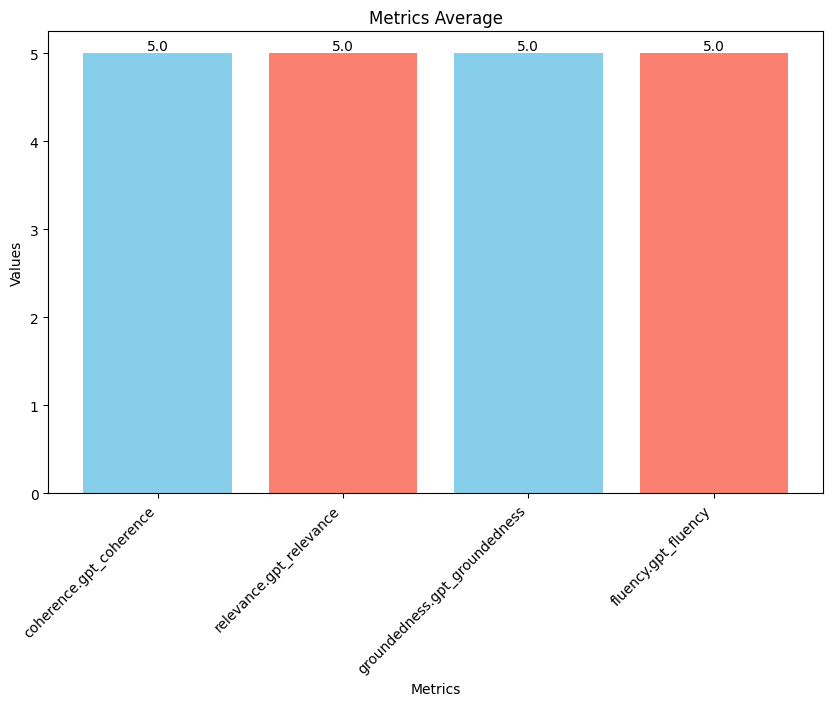

,query,response,context,ground_truth,coherence.gpt_coherence,relevance.gpt_relevance,groundedness.gpt_groundedness,fluency.gpt_fluency
0,GPTの活用について教えてください。,GPTの活用について、以下の情報を提供します。\n\n1. **自然言語におけるユースケース...,## filename: 20230217_AIの進化と日本の戦略_松尾研.pdf-5\n\...,,5,5,5,5
1,松尾教授について教えて,松尾教授についての情報は以下の通りです。\n\n松尾豊教授は、東京大学大学院工学系研究科の教...,## filename: 20230217_AIの進化と日本の戦略_松尾研.pdf-1\n\...,,5,5,5,5
2,生成AIについて教えて,生成AIについての情報は以下の通りです。\n\n生成AI（Generative AI）は、人...,## filename: 20230217_AIの進化と日本の戦略_松尾研.pdf-8\n\...,,5,5,5,5
3,GPTの活用方法について教えて,GPT（Generative Pre-trained Transformer）は、自然言語処...,## filename: 20230217_AIの進化と日本の戦略_松尾研.pdf-5\n\...,,5,5,5,5


In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# データの定義
data = result

# メトリクスの棒グラフ作成
metrics = data['metrics']
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(metric_names, metric_values, color=['skyblue', 'salmon'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Metrics Average')

# 各バーに値を表示
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height}', ha='center', va='bottom')

# X軸のラベルを45度回転
plt.xticks(rotation=45, ha='right')

plt.show()

# Rowsを表として表示
rows = data['rows']
df = pd.DataFrame(rows)

# Outputsカラムの抽出
output_columns = [col for col in df.columns if col.startswith('outputs')]

# 列名を見やすくするためにプレフィックスを削除
df.columns = [col.replace('inputs.', '').replace('outputs.', '') for col in df.columns]

# Outputsカラムの新しい名前を取得（プレフィックス削除後）
output_columns_renamed = [col.replace('outputs.', '') for col in output_columns]

df

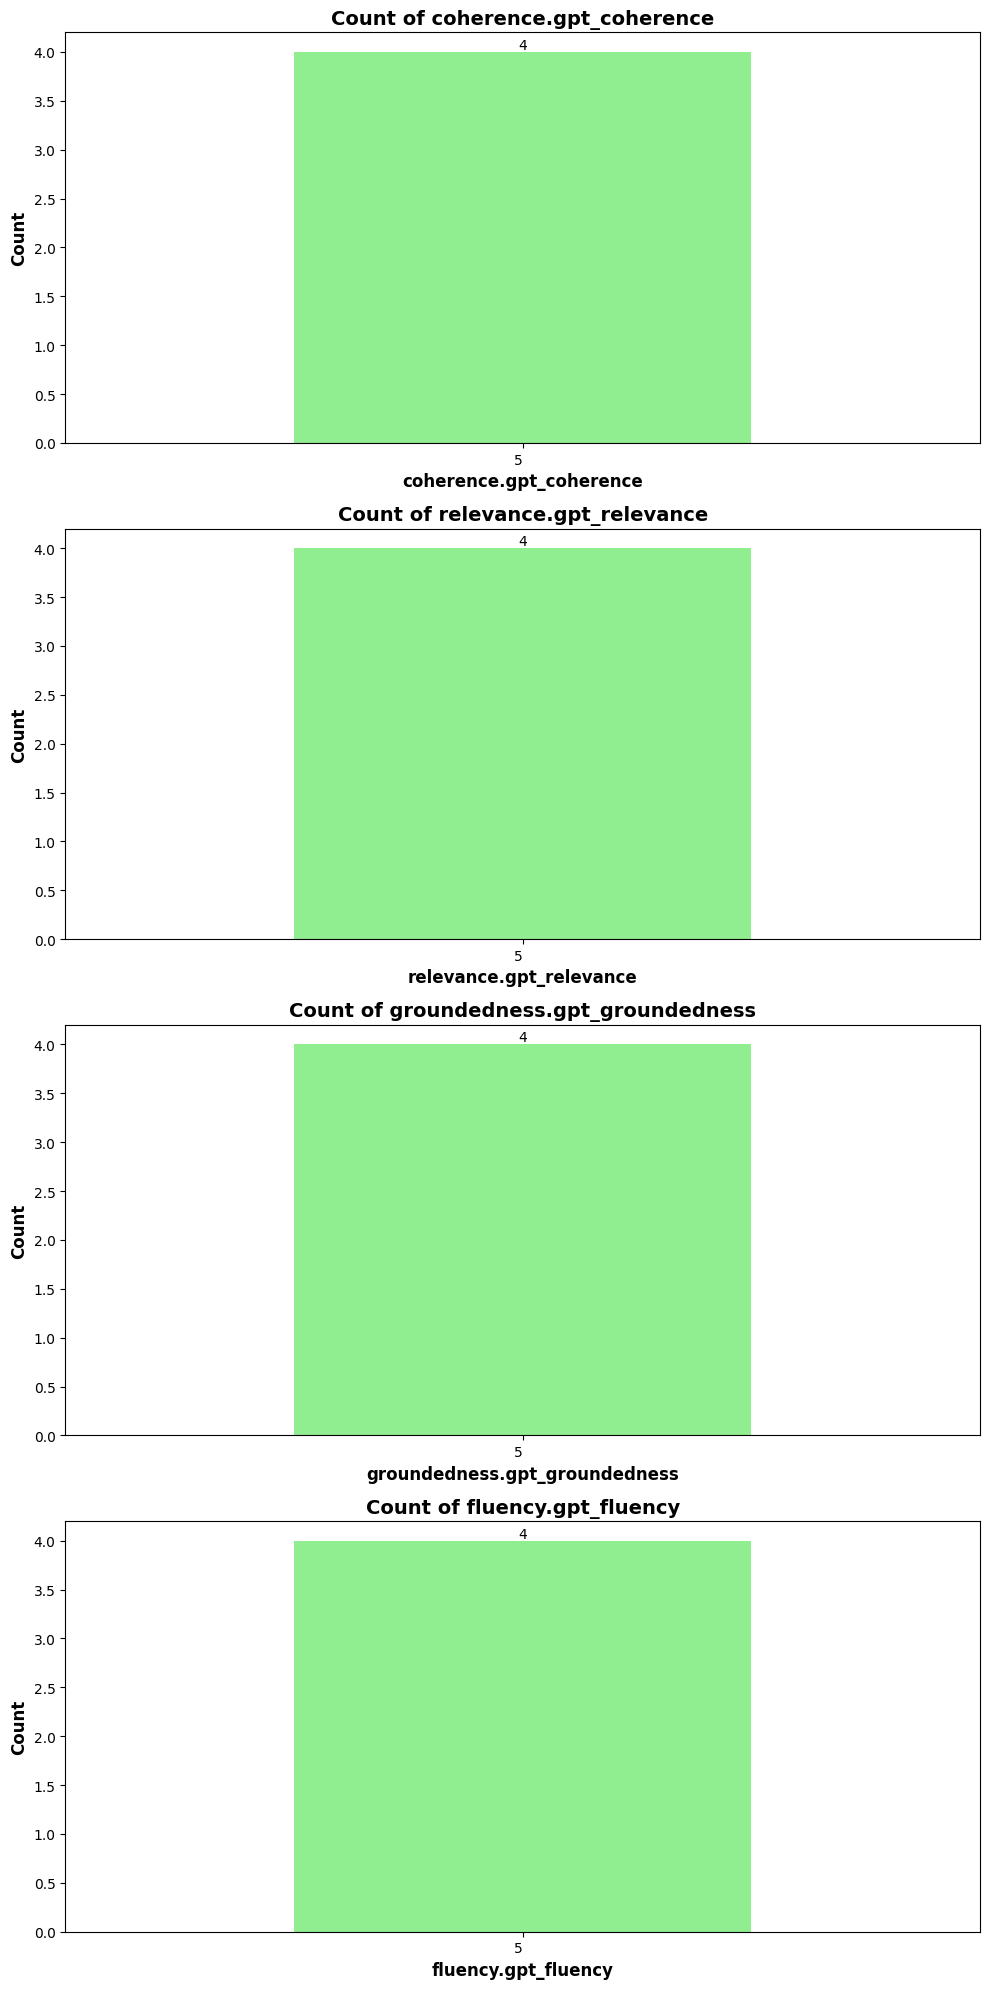

In [12]:
# Outputsカラムごとにカウントを取って棒グラフを作成
num_outputs = len(output_columns_renamed)
if num_outputs > 0:
    fig, axes = plt.subplots(num_outputs, 1, figsize=(10, 5 * num_outputs))
    if num_outputs == 1:
        axes = [axes]  # Ensure axes is iterable

    for ax, col in zip(axes, output_columns_renamed):
        if col in df.columns:
            counts = df[col].value_counts().sort_index()
            counts.plot(kind='bar', ax=ax, color='lightgreen')
            ax.set_xlabel(col, fontsize=12, fontweight='bold')
            ax.set_ylabel('Count', fontsize=12, fontweight='bold')
            ax.set_title(f'Count of {col}', fontsize=14, fontweight='bold')
            
            # X軸のラベルを0度回転
            ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right', fontsize=10)
            
            # 各バーに値を表示
            for p in ax.patches:
                ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='bottom', fontsize=10)
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")

    plt.tight_layout()
    plt.show()